In [1]:
library(tidyverse)
library(cisTopic)
library(plyr)
library(stringr)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“replacing previous import ‘GenomicRanges::shift’ by ‘data.table::shift’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘data.table::last’ by ‘dplyr::last’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘dplyr::union’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::intersect’ by ‘dplyr::intersect’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::setdiff’ by ‘dplyr::setdiff’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘da

In [13]:
# From raw peak matrix
archr.peakmatrix <-readRDS(file= "./CTRL_RA_archr_peakmatrix.rds")

cisTopicObject <- createcisTopicObject(count.matrix = archr.peakmatrix, 
                                       project.name = "CTRLvsRA",
                                       min.cells = 1,
                                       min.regions = 1,
                                       is.acc = 1,
                                       keepCountsMatrix=F)

In [14]:
archr_meta <- readRDS("./CTRLvsRA_archr_cellcoldata.rds")
cisTopicObject <- addCellMetadata(cisTopicObject, archr_meta)
# cisTopicObject@cell.data$cluster <- as.factor(cisTopicObject@cell.data$cluster)

In [16]:
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic=c(10:30, 35, 40), seed=987, nCores=1, iterations = 500, addModels=FALSE)

  |                                                                      |   0%INFO  [11:02:27.564] early stopping at 350 iteration 
INFO  [11:04:05.887] early stopping at 50 iteration 
  |...                                                                   |   4%INFO  [11:15:02.372] early stopping at 300 iteration 
INFO  [11:16:39.547] early stopping at 50 iteration 
  |......                                                                |   9%INFO  [11:29:21.911] early stopping at 350 iteration 
INFO  [11:30:59.516] early stopping at 50 iteration 
  |.........                                                             |  13%INFO  [11:42:01.852] early stopping at 300 iteration 
INFO  [11:43:39.098] early stopping at 50 iteration 
  |............                                                          |  17%INFO  [11:53:54.864] early stopping at 275 iteration 
INFO  [11:55:33.224] early stopping at 50 iteration 
  |...............                                                    

[1] "Are these CGS models? Please, use type=\"maximum\""


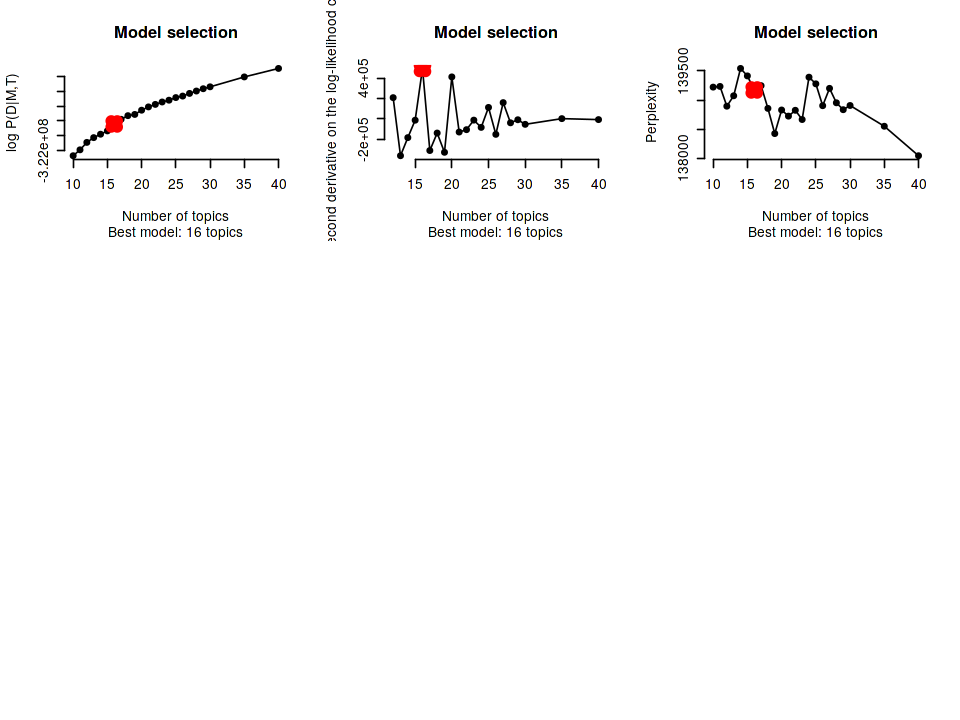

In [18]:
par(mfrow=c(3,3))
# cisTopicObject <- selectModel(cisTopicObject, type='maximum')
# cisTopicObject <- selectModel(cisTopicObject, type='perplexity')
cisTopicObject <- selectModel(cisTopicObject, type='derivative')

In [55]:
cellassign <- modelMatSelection(cisTopicObject, 'cell', 'Z-score')

In [56]:
cellassign.p <- modelMatSelection(cisTopicObject, 'cell', 'Probability')

In [57]:
saveRDS(t(cellassign.p),file='CTRL-RA-cistopic-cellassign-p.rds')

In [7]:
topic.score <- cellassign %>% t() %>% cbind(cisTopicObject@cell.data) %>% gather(Topic, score, Topic1:Topic16, factor_key=TRUE)

In [21]:
topic.score.subset <- cellassign %>% t() %>% cbind(cisTopicObject@cell.data) %>% gather(Topic, score, c(Topic6,Topic14), factor_key=TRUE)

In [15]:
options(repr.plot.width=15, repr.plot.height=4)
pdf("CTRLvsG9a.Cistopic.violin.pdf",width=12,height=4)
ggviolin(topic.score, x= "Topic", y= "score",fill="Sample",
         palette = c("#631879FF", "#008280FF")) 
dev.off()
# ggsave(file="CTRLvsG9a.Cistopic.violin.pdf",width = 8,
#        height = 3)

png 
  2

In [60]:
# cisTopicObject <- runtSNE(cisTopicObject, target='cell', seed=123, pca=FALSE, method='Probability')
cisTopicObject <- runUmap(cisTopicObject, target='cell', seed=123, method='Z-score',n_components=2)

In [54]:
set.seed(123)
library(Rtsne)
DR <- Rtsne(t(cellassign), pca=F)
DRdist <- dist(DR$Y)
library(densityClust)
dclust <- densityClust(DRdist,gaussian=T)

Distance cutoff calculated to 3.371662 


In [55]:
dclust <- findClusters(dclust, rho = 50, delta = 3.24)

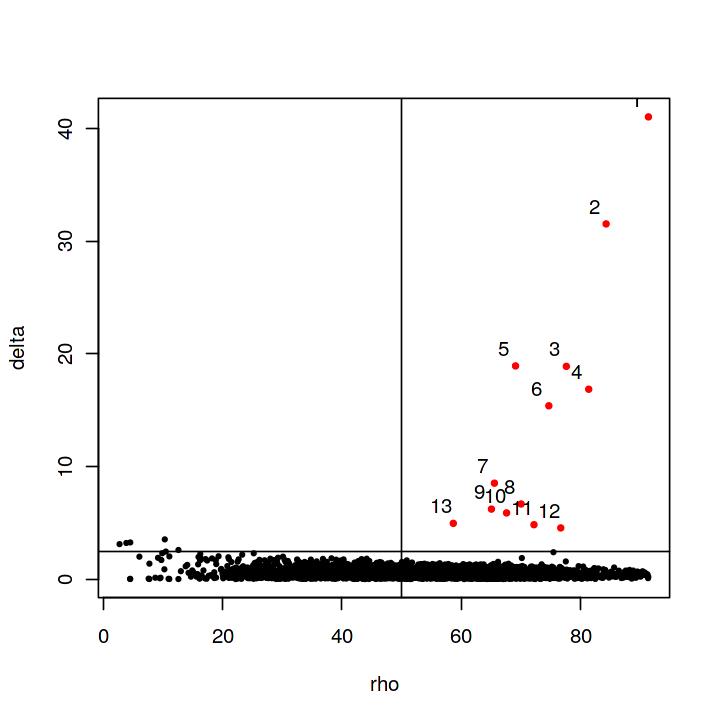

In [56]:
# Check thresholds
options(repr.plot.width=6, repr.plot.height=6)
plot(dclust$rho,dclust$delta,pch=20,cex=0.6,xlab='rho', ylab='delta')
points(dclust$rho[dclust$peaks],dclust$delta[dclust$peaks],col="red",pch=20,cex=0.8)
text(dclust$rho[dclust$peaks]-2,dclust$delta[dclust$peaks]+1.5,labels=dclust$clusters[dclust$peaks])
abline(v=50)
abline(h=2.5)

In [57]:
# Add cluster information
densityClust <- dclust$clusters
densityClust <- as.data.frame(densityClust)
rownames(densityClust) <- cisTopicObject@cell.names
colnames(densityClust) <- 'densityClust'
densityClust[,1] <- as.factor(densityClust[,1])
cisTopicObject <- addCellMetadata(cisTopicObject, densityClust)

In [63]:
colVars <- list()
col <- list()
col[["cluster"]] <- c("1" = "#E64B35FF","2" = "#4DBBD5FF","3" ="#00A087FF","4" ="#3C5488FF","5" ="#F39B7FFF","6" ="#8491B4FF")
col[["Sample"]] <- c(CTRL = "#631879FF",RA = "#008280FF")

In [64]:
colVars <- list()
col <- list()
col[["cluster"]] <- c("1" = "#E64B35FF","2" = "#4DBBD5FF","3" ="#00A087FF","4" ="#3C5488FF","5" ="#F39B7FFF","6" ="#8491B4FF")
col[["Sample"]] <- c(CTRL = "#e98e8eff",RA = "#74aadfff")

In [48]:
pdf(file="cisTopic_RA.pdf",width=8, height=8)
options(repr.plot.width=10,repr.plot.height=10)
par(mfrow=c(2,2))
plotFeatures(cisTopicObject,colVars=col, dim = 2,method='tSNE',cex.dot = 0.75,target='cell', topic_contr=NULL, colorBy=c('cluster','Sample'), cex.legend = 0.8, factor.max=0.5,  legend=TRUE, col.low='darkgreen', col.mid='yellow', col.high='red', intervals=10)
dev.off()

png 
  2

In [60]:
object.cell.data <- cisTopicObject@cell.data
annotation <- ComplexHeatmap::HeatmapAnnotation(df = object.cell.data[,'cluster',drop=FALSE], col = col, which='column')# col.low = "blue", col.mid = "floralwhite", col.high = "red"
colorPal <- grDevices::colorRampPalette(c("blue", "floralwhite", "red"))
topic.mat <- modelMatSelection(cisTopicObject, 'cell', 'Z-score')
# paste1('Topic', seq(1,nrow(topic.mat)))
# cisTopicObject@cell.names
# topic.mat
ComplexHeatmap::Heatmap(data.matrix(topic.mat), 
                        col=colorPal(20),top_annotation = annotation, 
                        cluster_columns=FALSE, name='Z-score',
                                       show_column_names=FALSE, show_row_names = TRUE, 
                                       heatmap_legend_param = list(legend_direction = "horizontal", legend_width = unit(5, "cm"), title_position='topcenter'),
                                       column_title = "Topic contribution per cell", column_title_gp = gpar(fontface = 'bold'))

ERROR: Error: `col` should be a named list.


In [65]:
annotation <- ComplexHeatmap::HeatmapAnnotation(df = object.cell.data[,'Sample',drop=FALSE], col = col, which='column')# col.

In [47]:
object.cell.data <- cisTopicObject@cell.data
annotation <- ComplexHeatmap::HeatmapAnnotation(df = object.cell.data[,'Sample',drop=FALSE], col = col, which='column')# col.low = "blue", col.mid = "floralwhite", col.high = "red"
colorPal <- grDevices::colorRampPalette(c("blue", "floralwhite", "red"))
topic.mat <- modelMatSelection(cisTopicObject, 'cell', 'Z-score')
# paste1('Topic', seq(1,nrow(topic.mat)))
# cisTopicObject@cell.names
# topic.mat
pdf("cisTopic_CTRLvsRA_topic_heatmap.horizon.Sampleorder.pdf",width = 6 , height = 8)
ComplexHeatmap::Heatmap(data.matrix(topic.mat), 
                        col=colorPal(20),top_annotation = annotation, 
                        cluster_columns=FALSE, name='Z-score',
                                       show_column_names=FALSE, show_row_names = TRUE, 
                                       heatmap_legend_param = list(legend_direction = "vertical", legend_width = unit(5, "cm"), title_position='topcenter'),
                                       column_title = "Topic contribution per cell", column_title_gp = gpar(fontface = 'bold'))
dev.off()

png 
  2

In [20]:
# pdf("cisTopic_CTRLvsRA_topic_heatmap.horizon.pdf",width = 6 , height = 4)
options(repr.plot.height=4,repr.plot.width=6)
cellTopicHeatmap(cisTopicObject, cluster_columns = FALSE, 
#                  colVars= col, 
                 method='Z-score', colorBy=c('cluster','Sample'), col.low = "blue", col.mid = "floralwhite", col.high = "red")
# cellTopicHeatmap(cisTopicObject, colVars= col, method='Z-score', colorBy=c('cluster','Sample'), col.low = "#440154FF", col.mid = "#29AF7FFF", col.high = "#FDE725FF")
# cellTopicHeatmap(cisTopicObject, colVars= col, method='Z-score', colorBy=c('cluster','Sample'), col.low = "dodgerblue", col.mid = "floralwhite", col.high = "brown1")
# dev.off()

ERROR: Error in ComplexHeatmap::Heatmap(data.matrix(topic.mat), col = colorPal(20), : formal argument "cluster_columns" matched by multiple actual arguments


In [48]:
cells <- cisTopicObject@cell.data %>% filter(Sample == 'CTRL') %>% rownames()
subset_counts <- cisTopicObject@binary.count.matrix[,cells]
subset_metadata <- cisTopicObject@cell.data[cells,]
subset_cisTopicObject <- createcisTopicObject(subset_counts)
subset_cisTopicObject <-  addCellMetadata(subset_cisTopicObject, subset_metadata)
subset_cisTopicObject@dr[["cell"]][['tSNE']]<- cisTopicObject@dr[["cell"]][['tSNE']][cells,]
subset_cisTopicObject@selected.model <- cisTopicObject@selected.model
subset_cisTopicObject@selected.model$document_expects <- subset_cisTopicObject@selected.model$document_expects[,cells]
subset_cisTopicObject@selected.model$document_sums <- subset_cisTopicObject@selected.model$document_sums[,cells]

In [51]:
cellassign <- modelMatSelection(subset_cisTopicObject, 'cell', 'Probability')

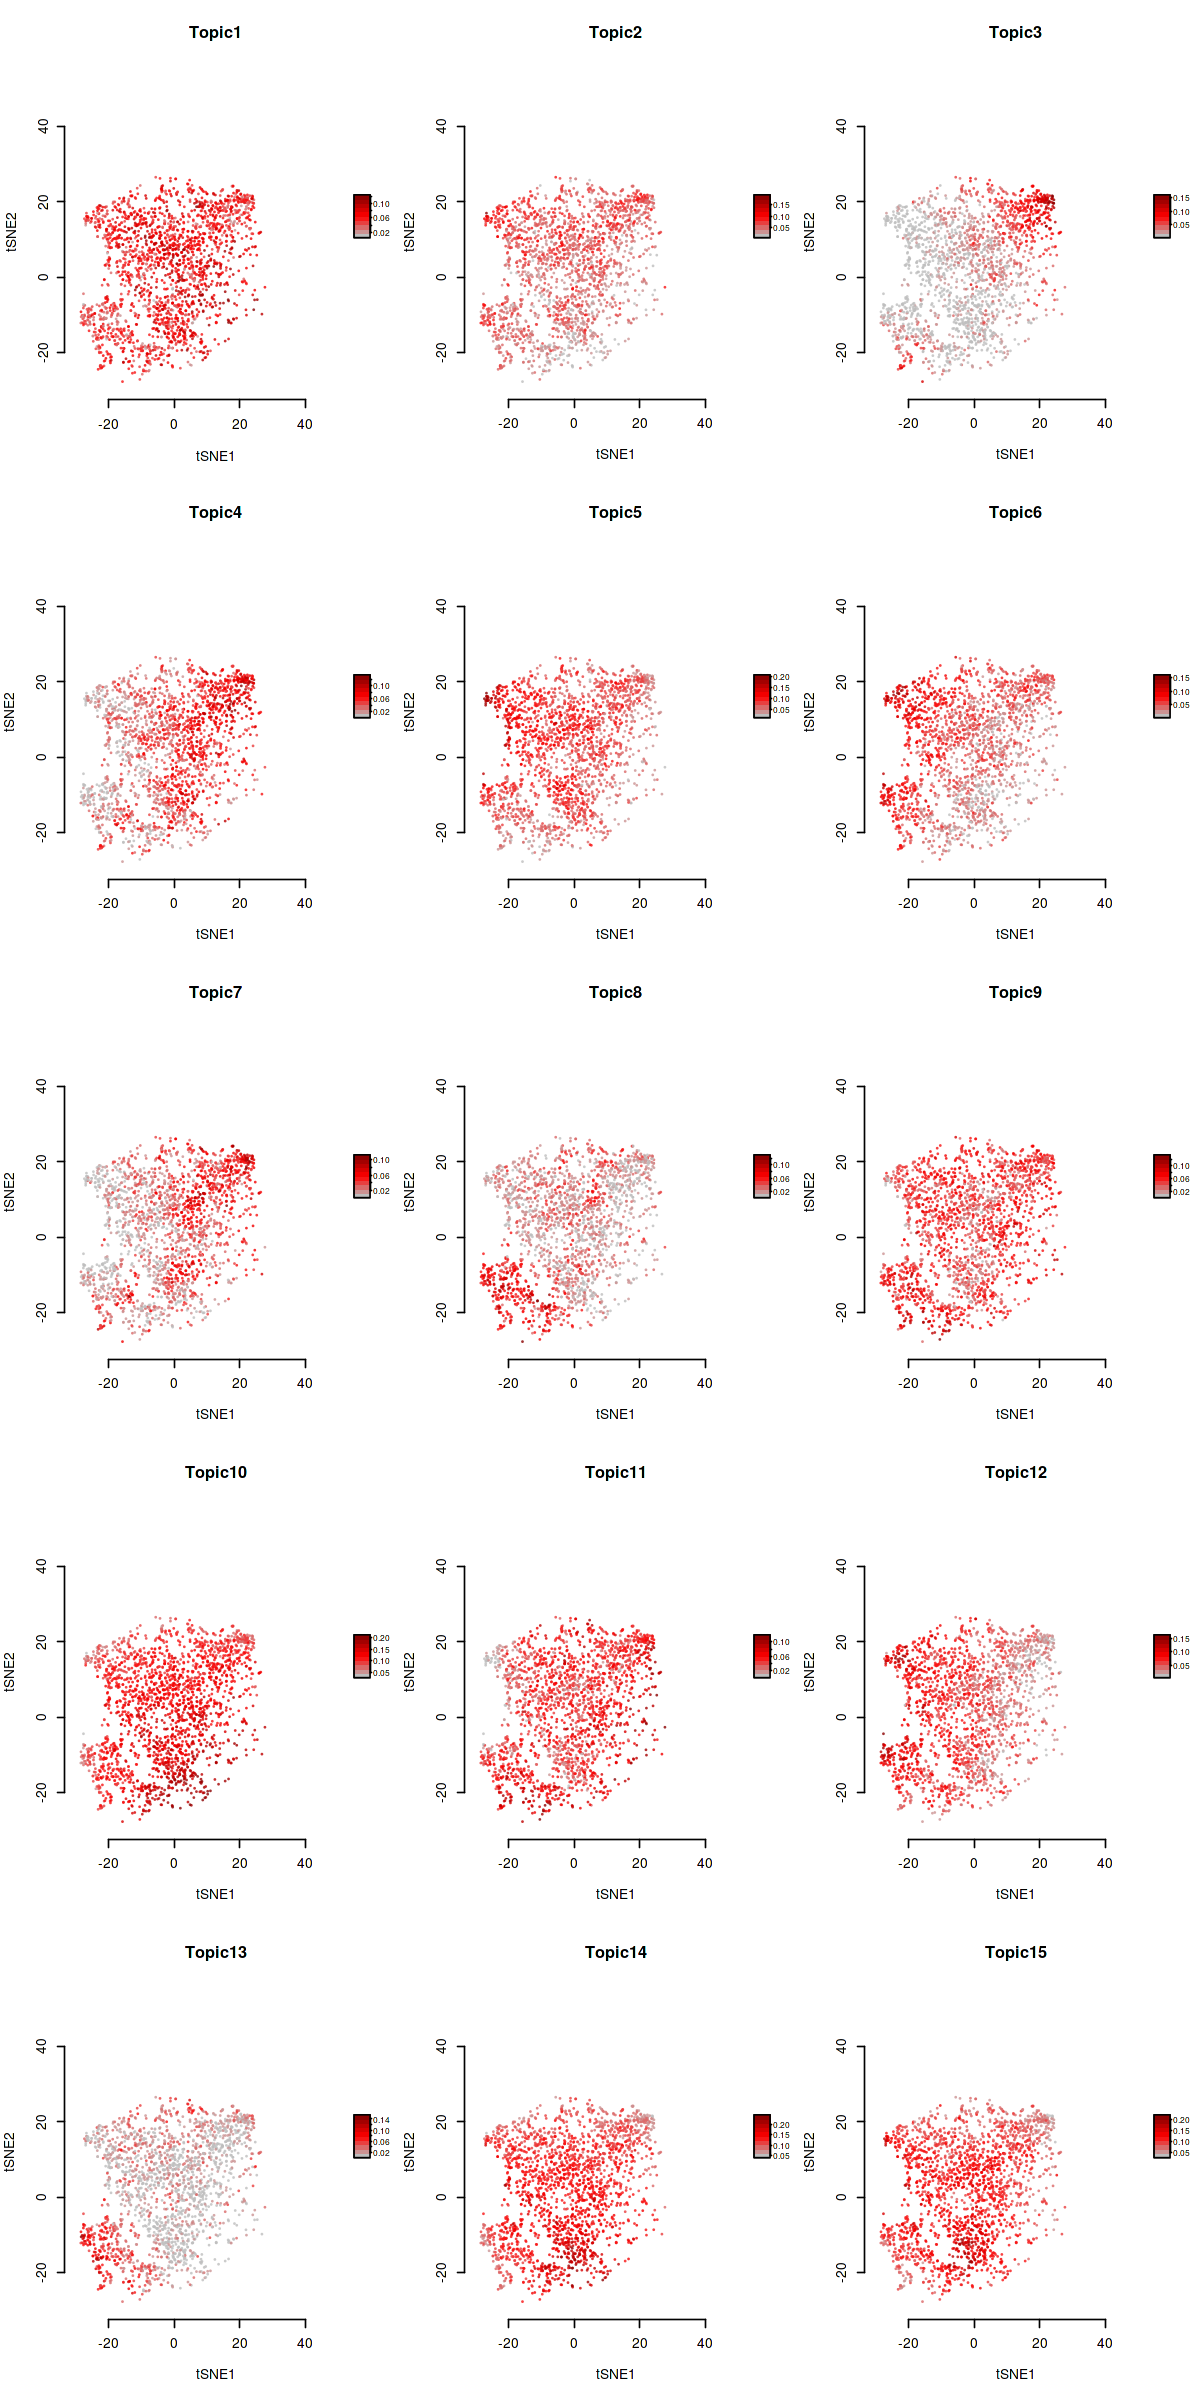

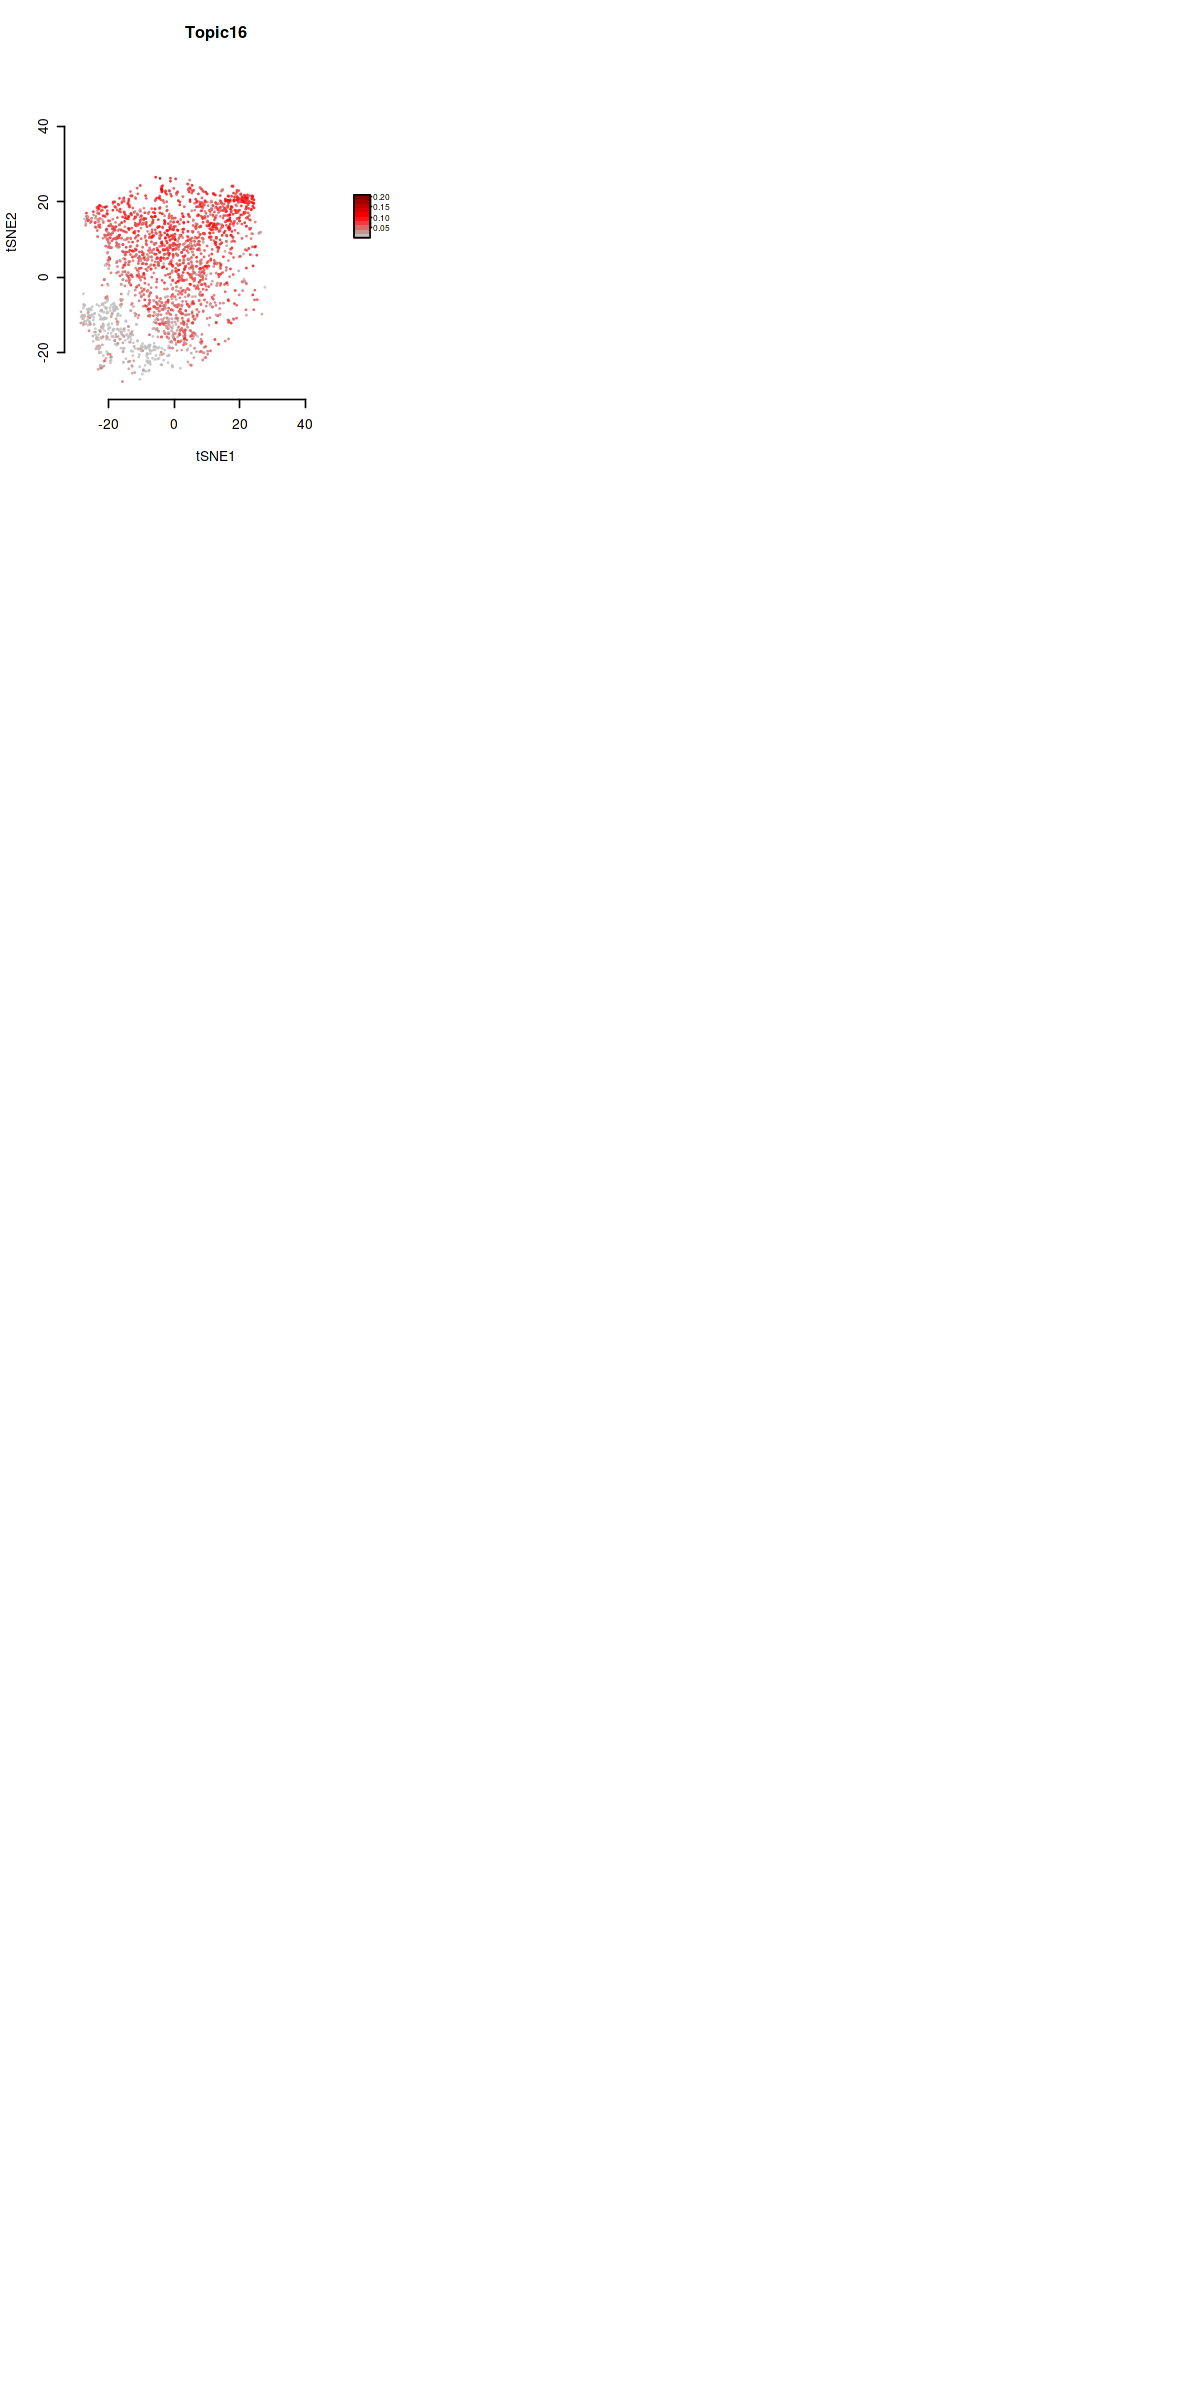

In [49]:
options(repr.plot.width=10,repr.plot.height=20)
par(mfrow=c(5,3))
plotFeatures(subset_cisTopicObject, method='tSNE', col.low = "grey",  col.high = "darkred",target='cell',cex.dot = 0.3, topic_contr='Probability', colorBy=NULL, cex.legend = 0.8, factor.max=1, dim=2, legend=TRUE)




In [46]:
cells <- cisTopicObject@cell.data %>% filter(Sample == "RA") %>% rownames()
subset_counts <- cisTopicObject@binary.count.matrix[,cells]
subset_metadata <- cisTopicObject@cell.data[cells,]
subset_cisTopicObject <- createcisTopicObject(subset_counts)
subset_cisTopicObject <-  addCellMetadata(subset_cisTopicObject, subset_metadata)
subset_cisTopicObject@dr[["cell"]][['tSNE']]<- cisTopicObject@dr[["cell"]][['tSNE']][cells,]
subset_cisTopicObject@selected.model <- cisTopicObject@selected.model
subset_cisTopicObject@selected.model$document_expects <- subset_cisTopicObject@selected.model$document_expects[,cells]
subset_cisTopicObject@selected.model$document_sums <- subset_cisTopicObject@selected.model$document_sums[,cells]

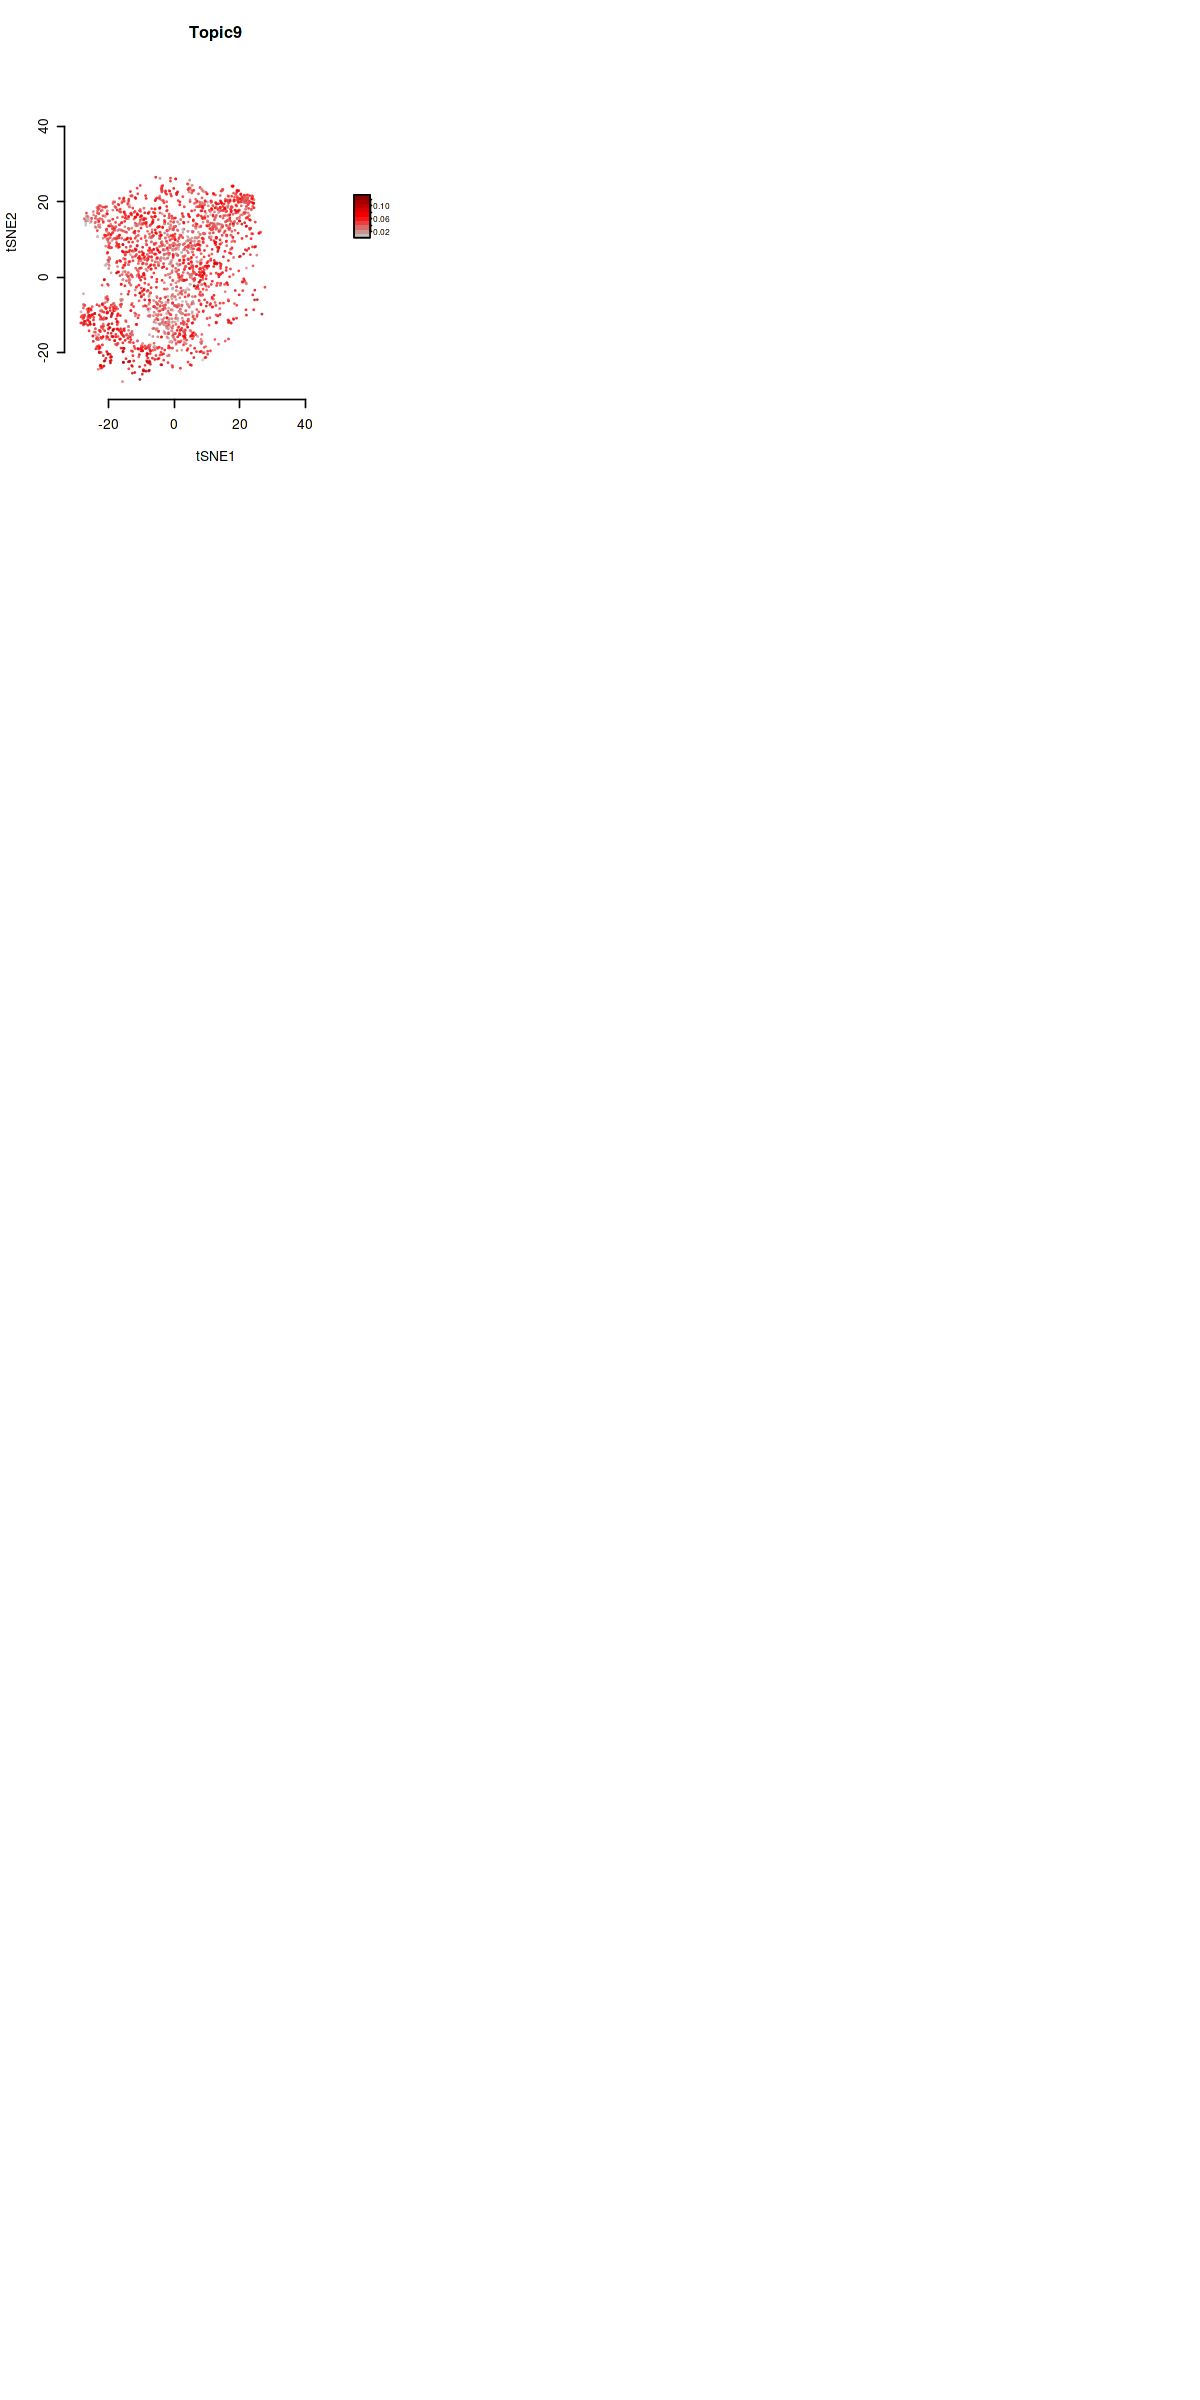

In [50]:
options(repr.plot.width=10,repr.plot.height=20)
par(mfrow=c(5,3))
plotFeatures(subset_cisTopicObject,topics= 'Topic9', method='tSNE', col.low = "grey",  col.high = "darkred",target='cell',cex.dot = 0.3, topic_contr='Probability', colorBy=NULL, cex.legend = 0.8, factor.max=1, dim=2, legend=TRUE)





In [16]:
archr_meta <- readRDS("./CTRLvsRA_archr_cellcoldata.rds")
subset_cisTopicObject <- addCellMetadata(subset_cisTopicObject, archr_meta)
# cisTopicObject@cell.data$cluster <- as.factor(cisTopicObject@cell.data$cluster)
# subset_cisTopicObject <-  AddCellMetadata(subset_cisTopicObject, subset_metadata)

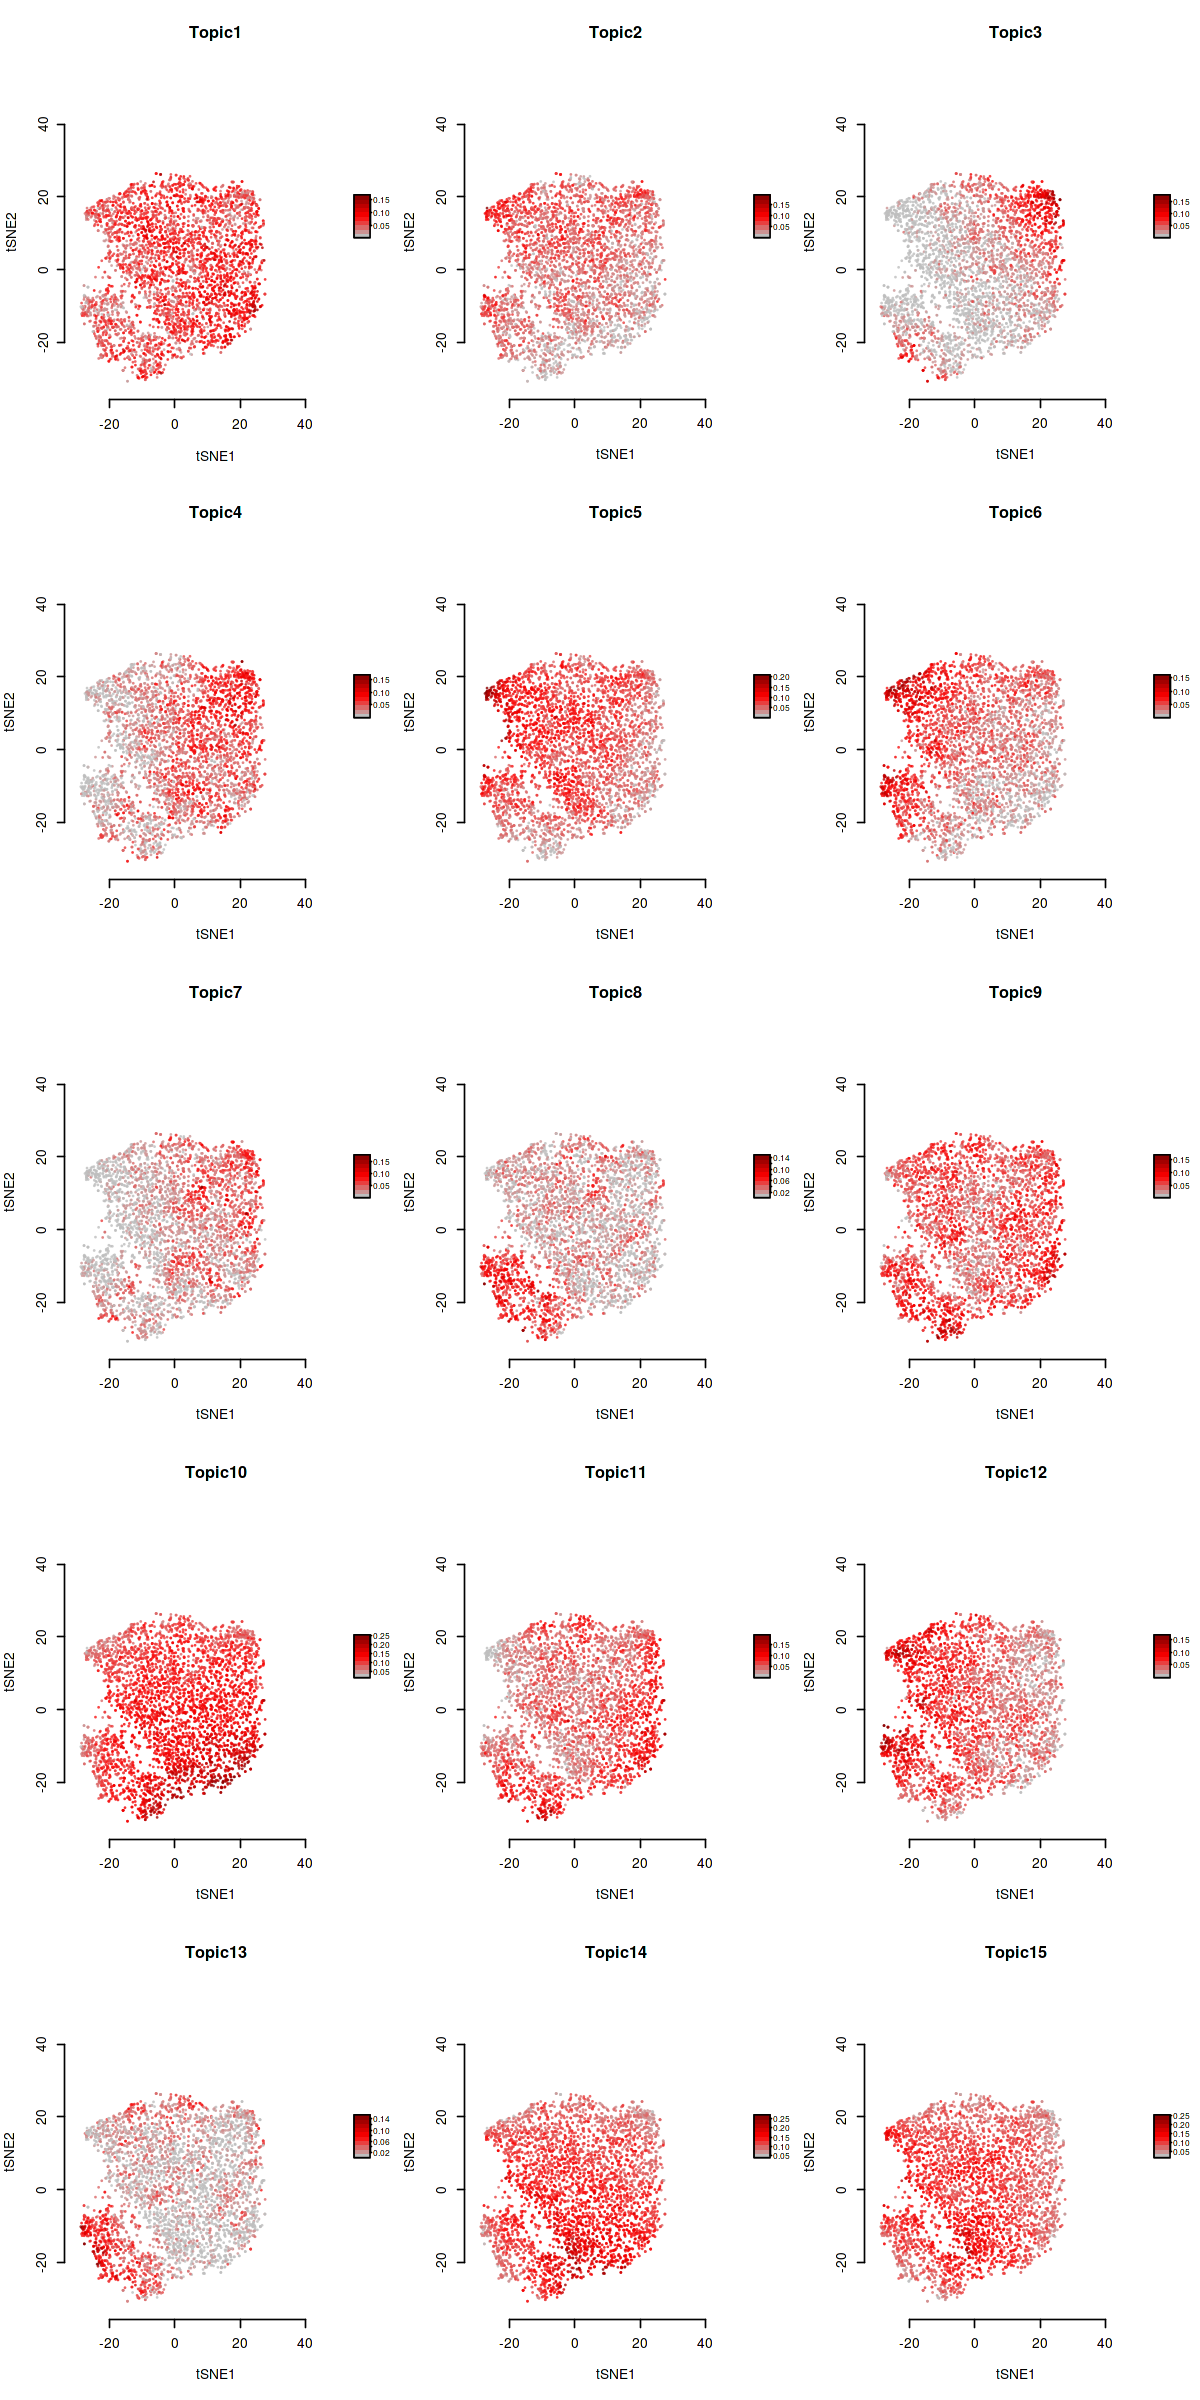

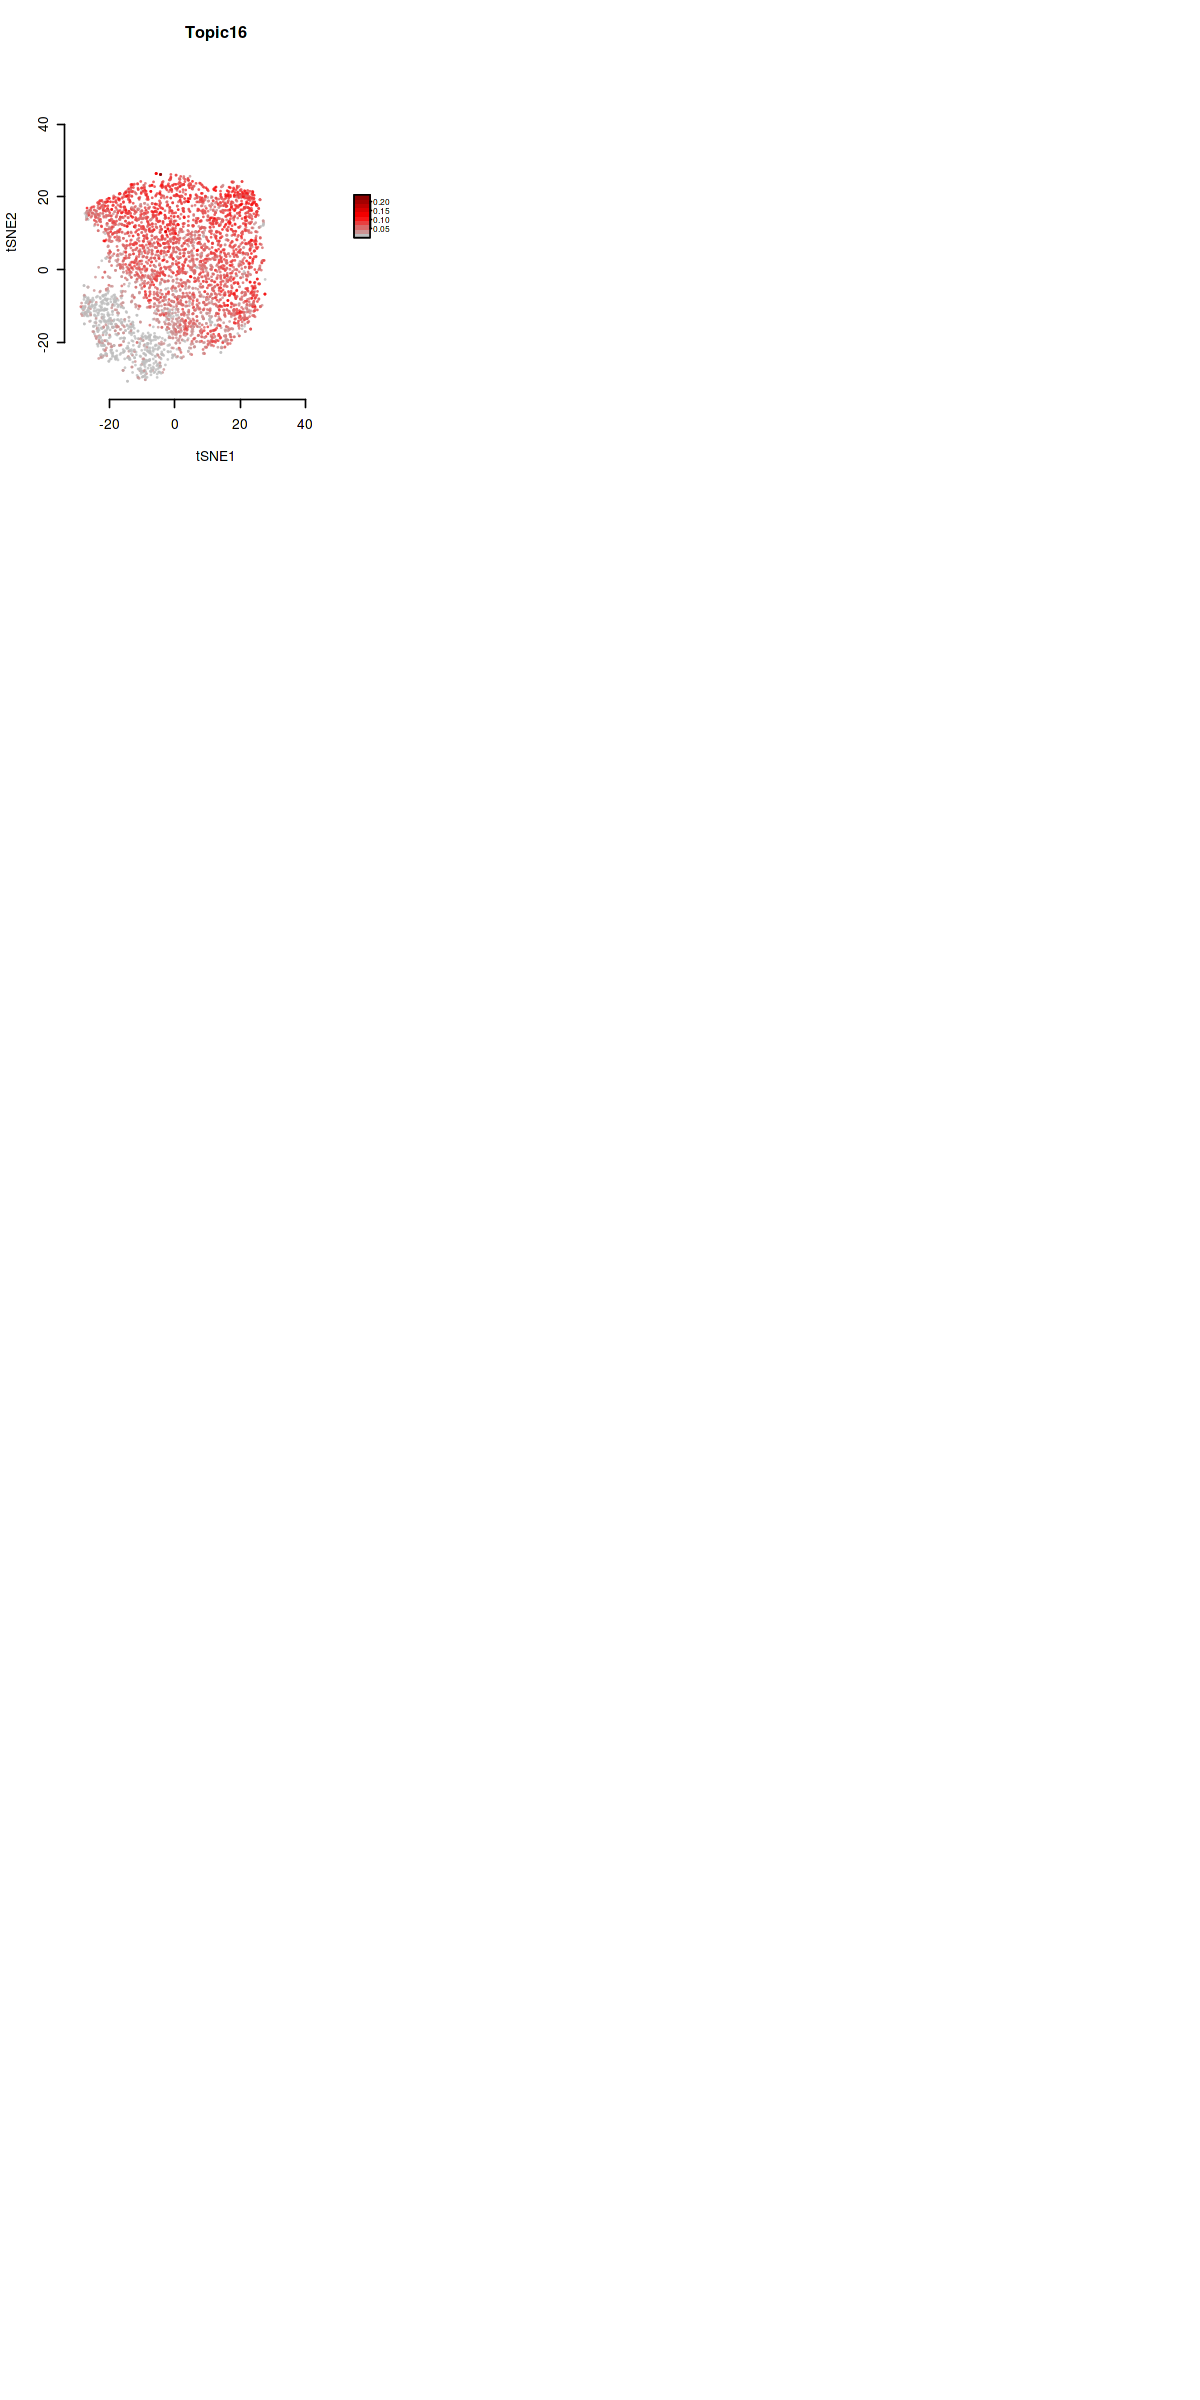

In [25]:
options(repr.plot.width=10,repr.plot.height=20)
par(mfrow=c(5,3))
plotFeatures(cisTopicObject, method='tSNE', col.low = "grey",  col.high = "darkred",target='cell',cex.dot = 0.3, topic_contr='Probability', colorBy=NULL, cex.legend = 0.8, factor.max=1, dim=2, legend=TRUE)


In [27]:
pdf("cisTopic_CTRLvsRA_topic910111.pdf",width = 10 , height = 20)
options(repr.plot.width=10,repr.plot.height=20)
par(mfrow=c(5,3))
plotFeatures(cisTopicObject, method='tSNE', col.low = "grey",  col.high = "darkred",target='cell',cex.dot = 0.75, topic_contr='Probability', colorBy=NULL, topics= c("Topic9", "Topic10", "Topic11"), cex.legend = 0.8, factor.max=1, dim=2, legend=TRUE)
dev.off()

png 
  2

Loading required package: fitdistrplus

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:plotly':

    select


The following object is masked from 'package:dplyr':

    select


Loading required package: survival



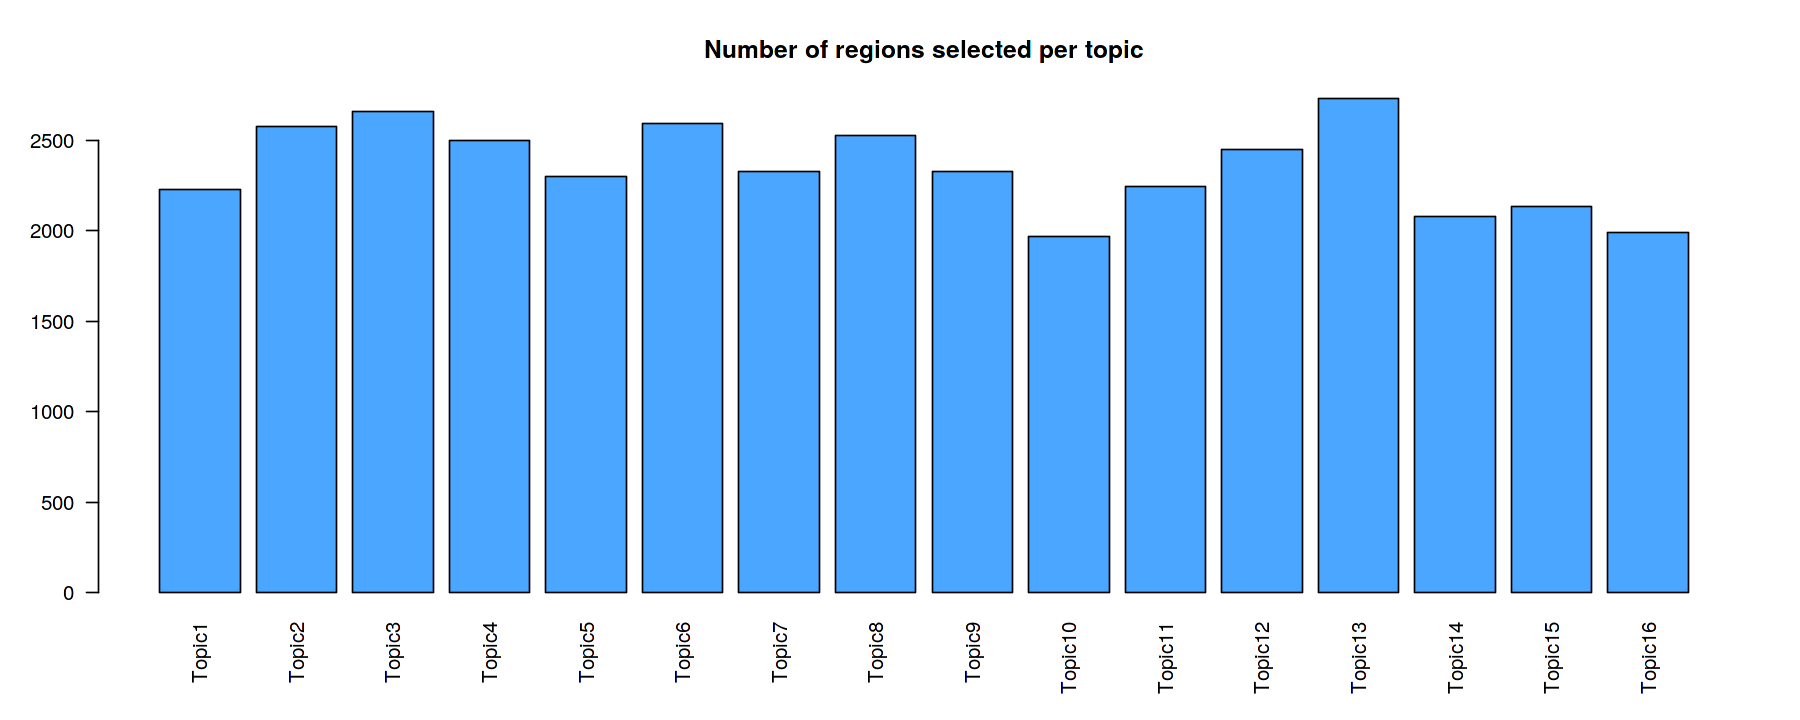

In [41]:
cisTopicObject <- getRegionsScores(cisTopicObject, method='NormTop', scale=TRUE)
cisTopicObject <- binarizecisTopics(cisTopicObject, thrP=0.99, plot=FALSE)

In [4]:
getBedFiles(cisTopicObject, path='CTRL.RA.archr.cisTopics_asBed.2021')

ERROR: Error in getBedFiles(cisTopicObject, path = "CTRL.RA.archr.cisTopics_asBed.2021"): object 'cisTopicObject' not found


In [42]:
cisTopicObject <- GREAT(cisTopicObject, genome='mm10', fold_enrichment=1.5, geneHits=1, sign=0.05, request_interval=10)

Loading required package: rGREAT


------------------
Note: On Aug 19 2019 GREAT released version 4 where it supports `hg38`
genome and removes some ontologies such pathways. `submitGreatJob()`
still takes `hg19` as default. `hg38` can be specified by the `species
= 'hg38'` argument. To use the older versions such as 3.0.0, specify as
`submitGreatJob(..., version = '3.0.0')`.
------------------



In [31]:
job <- list()
topic.bedlist <- list.files("CTRL.RA.archr.cisTopics_asBed.2021",full.names = TRUE)

In [50]:
job <- submitGreatJob(import(topic.bedlist[9], format="bed"), species = "mm10") 

Don't make too frequent requests. The time break is 300s.
Please wait for 64s for the next request.
The time break can be set by `request_interval` argument.




  |===================================================================== |  99%


In [35]:
for (i in length(topic.bedlist)) {
    job[i] <- submitGreatJob(topic.bedlist[i], species = "mm10")   
}


Warning message in `[<-`(`*tmp*`, i, value = submitGreatJob(topic.bedlist[i], species = "mm10")):
“implicit list embedding of S4 objects is deprecated”


In [7]:
options(repr.plot.width =10, repr.plot.height=10)

In [9]:
pdf(file="cisTopic_RA_topic256_dotplot.pdf",width=9, height=5)
ontologyDotPlot(cisTopicObject, top=10, topics=c(2,5,6),var.size = "Hyper_Observed_Gene_Hits", var.y='name', order.by='Hyper_Observed_Gene_Hits') +
        scale_color_viridis(option = "D",direction = -1) + scale_size(range=c(1, 8))+
        theme(axis.text=element_text(size=10,face="bold"),
        axis.title=element_text(size=18,face="bold"))
dev.off()

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.



png 
  2

In [11]:
pdf(file="cisTopic_RA_topic9-11_dotplot.pdf",width=9, height=5)
ontologyDotPlot(cisTopicObject, top=10, topics=c(9,10,11),var.size = "Hyper_Observed_Gene_Hits", var.y='name', order.by='Hyper_Observed_Gene_Hits') +
        scale_color_viridis(option = "D",direction = -1) + scale_size(range=c(1, 8))+
        theme(axis.text=element_text(size=10,face="bold"),
        axis.title=element_text(size=18,face="bold"))
dev.off()

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.



png 
  2

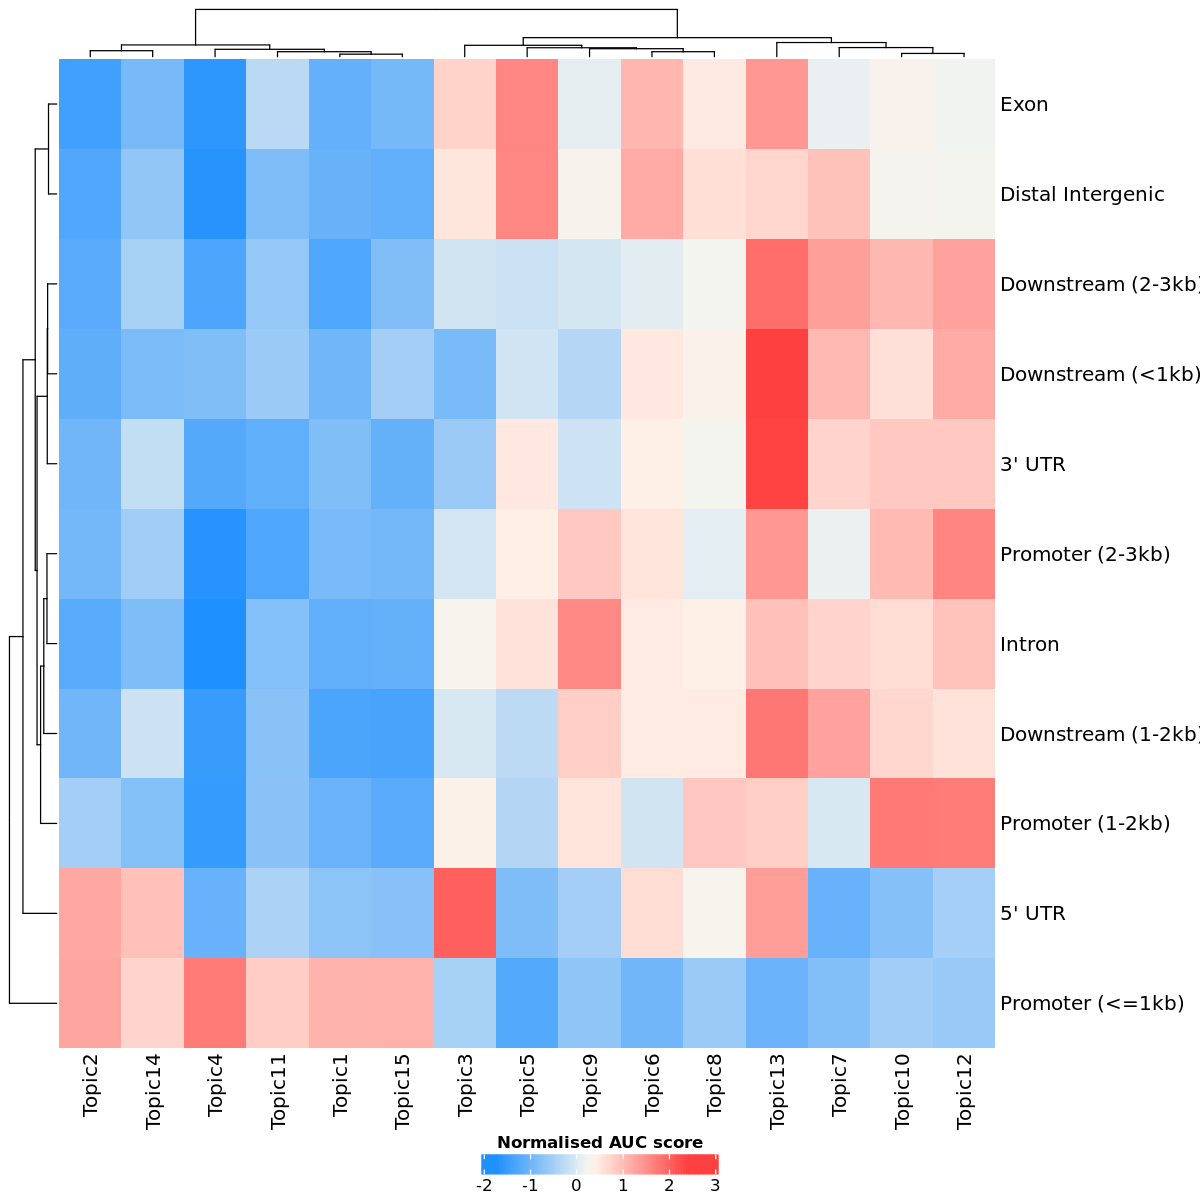

In [67]:
par(mfrow=c(1,1))
signaturesHeatmap(cisTopicObject, selected.signatures = 'annotation')
# plotFeatures(cisTopicObject, method='UMAP', target='region', topic_contr=NULL, colorBy=c('annotation'), cex.legend = 0.8, factor.max=.75, dim=2, legend=TRUE, intervals=20)

In [62]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] rtracklayer_1.46.0   plyr_1.8.6           rGREAT_1.18.0       
 [4] GenomicRanges_1.38.0 GenomeInfoDb_1.22.1  IRanges_2.20.2      
 [7] S4Vectors_0.24.4     BiocGenerics_0.32.0  scatterplot3d_0.3-41
[10] plotly_4.9.3         ggplot2_3.3.3 